# Web "stuff" in Python

- HCI 574 lectures 35 thru 38

- disclaimer: I'm just a "bit dangerous" when it really comes to web stuff, some of you may know much more and have used far more advanced tools
- I assume you're somewhat familiar with HTML and and the URL mechanic


I'm postulating this scenario:
- you're writing python code for an app
- the app could just be a regular python script or it could be wrapped into a server that a browser could connect to, making it a web app.
- there's some sort of data you want from a web server (e.g. a 1.jpg)
- you request that image via a URL: e.g. https://xkcd.com/1/  (maybe /1/ -> 1.jpp)
- the server returns some sort of data: the actual file, another URL to the file, a JSON "file" with data in it
- you receive the data with your app
- you display it, process it, save to to a local file system, transmit it it another server, etc.


- if you're writing a web app,  your input and output happens in (through) a browser, and you'll have to use HTML and Javascript (as GUI) or one of the many other, more modern JS libraries/frameworks, such as JQuery and React - which I have never explored, as frontend which needs to interface with your (server, backend) python code. 
- if you're writing a web app, the server running it (serving the app to a browser) can either a local (development, debug) server (URL: `http://127.0.0.1`), or it can be deployed on a external server, e.g. pythonanywhere.com, where it needs some additional infrastructure (e.g. apache)



- this is __my__ (amateur) understanding, please feel free to correct or add to this! 

## Web scraping a image file
- https://xkcd.com/ makes it really easy to request an image b/c the next part of the URL is a "folder" number that when requested, will return a html doc, that has a URL for the image somewhere,

- you can simulate/test this just by putting this in your browser:

https://xkcd.com/1/

- when the server receives the request it will return an html doc.
- Look at the source of this doc in your browser and do a find for  .jpg. You will find several, but the actual comic is sensably inside a div with the id _comic_:


```
<div id="comic">
<img src="//imgs.xkcd.com/comics/barrel_cropped_(1).jpg" title="Don&#39;t we all." alt="Barrel - Part 1" />
</div>
```

- the URL of the image source (after src=) is: `//imgs.xkcd.com/comics/barrel_cropped_(1).jpg` which you can paste into your browser and have it d/l the jpg for you and display it (browsers can display standard formats like .jpg, .gif. png, etc.)

- http://imgs.xkcd.com/comics/barrel_cropped_(1).jpg  (I put `http:` in front so jupyter shows it as a link you can click on but it should work even without that when you paste it ...)


- Note that your browser did NOT save the image to your disk, it just keeps it in memory
- With this we can now write a simple image scraper!

- For implicity I'll just scrape one random image at a time
- the image number will be between 1 and 2000

Steps:
- get random number 1 - 2000
- make a proper URL from `http://xkcd.com` and the number: `http://xkcd.com/<number>/`
- simulate a brower request of that web page using the [requests](https://requests.readthedocs.io/en/master/) package
- parse (analyse) the html text returned by requests (assuming no error!)
- find the `div` tag with id=comic, dig out the `img` tag inside and get the value for `src`
- This could be done via simple string manipulation but there's a package that makes this stuff very easy called [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) (`bs4`)
- Assemble a full URL "http:"  + "//imgs.xkcd.com/comics/barrelcropped(1).jpg"
- Do something with it
- First we'll download the jpg to a local folder and show it via PIL, later we'll just put this URL in our own HTML page and serve it via our own server app, so it'll be shown inside a browser instead via PIL


........


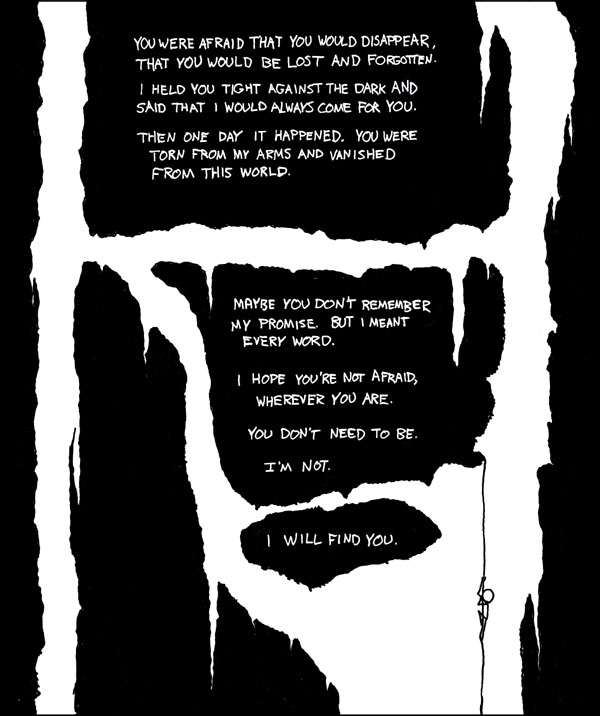

In [1]:
# Download a random single XKCD comic.
# based on https://automatetheboringstuff.com/chapter11/ written by Al Sweigert

import requests, os, bs4
from PIL import Image # so we can show the image
from IPython.display import display  # to show an image inside jupyter
from random import randint

# make a folder, if it not already exists
os.makedirs('xkcd', exist_ok=True) # store comics in ./xkcd

def get_xkcd_image_URL(n:int):  # type hint
    ''' return url to image of comix number n (int)'''
    url = 'http://xkcd.com' # base url
    n_str = str(n)
    url += f"/{n_str}/" # full comic page URL
    #print('page URL:', url)

    # Download the page.
    res = requests.get(url)
    res.raise_for_status() # will stop if request did not get 200 (e.g. if it got 404)

    # Use BSoup to find the URL of the comic image.
    soup = bs4.BeautifulSoup(res.text,  "html.parser")  
    comicElem = soup.select('#comic img') # grab the img tag inside the id=comic div
    if comicElem == []:
        print('Could not find comic image.')
    else:
        imgURL = "http:" + comicElem[0].get('src') # get the link URL
        return imgURL

# random int
n = randint(1, 2000)
comicUrl = get_xkcd_image_URL(n)

# Download the image.
res = requests.get(comicUrl)
res.raise_for_status()

# Save the image to ./xkcd
filename = os.path.join('xkcd', os.path.basename(comicUrl))
imageFile = open(filename, 'wb')
# stage the download in 10kb chunks (not needed here, but good for large files!)
for chunk in res.iter_content(10000):
    imageFile.write(chunk)
    print(".", end="") # progress bar
imageFile.close()
print()

# read image back in in and show it
img = Image.open(filename)
display(img)


## Create a html page with the scraped content
- Lets make a html doc that would show 3 images (via their URL) as thumbnail
- We won't d/l and shrink the images, we'll just use styling to make them appear shrunk
- Here's an suport shoddy html file example (open example.html in another editor)

In [2]:
from IPython.display import IFrame

# render html doc in jupyter
IFrame(src="example.html", width=600, height=300)

# On a real server, you'd be able to see the full image when clicking on the thumbnail!

In [3]:
# make a similar thumbnail HTML page with some random urls
def make_xkcd_thumbnail_html(num_thumbnails):
    ''' make a html page with x thumbnail links and save to file'''
    HTML = ""
    for i in range(0, num_thumbnails):
        n = randint(1, 2000)
        url = get_xkcd_image_URL(n)
        HTML += f'''
    <a target="_blank" href="{url}">
        <img src="{url}"  style="width:150px"> </a>'''
    return HTML

HTML = make_xkcd_thumbnail_html(3)
print(HTML)

# save into file
with open("test.html", "w+") as fo:
    print(HTML, file=fo) 


    <a target="_blank" href="http://imgs.xkcd.com/comics/myspace.png">
        <img src="http://imgs.xkcd.com/comics/myspace.png"  style="width:150px"> </a>
    <a target="_blank" href="http://imgs.xkcd.com/comics/qr_code.png">
        <img src="http://imgs.xkcd.com/comics/qr_code.png"  style="width:150px"> </a>
    <a target="_blank" href="http://imgs.xkcd.com/comics/geeks_and_nerds.png">
        <img src="http://imgs.xkcd.com/comics/geeks_and_nerds.png"  style="width:150px"> </a>


In [7]:
# render html doc in jupyter
IFrame(src="test.html", width=600, height=400)

### Convert into a web app (flask server)
- Flask is a micro framework 
    - https://flask.palletsprojects.com/en/1.1.x/
    - https://pythonbasics.org/what-is-flask-python/
    - https://realpython.com/tutorials/flask/
    - https://www.fullstackpython.com/flask.html
    
- will run a local Flask server
- will serve a html page to "http://127.0.0.1:5000" (5000 is the port number)
- uses decorators: 
    - https://realpython.com/primer-on-python-decorators/
    - will modify a function you are writing to make it work within it's own object model
    - effect: similar to subclassing a flask class but with __much les code__
- routes: function/method called when a browser requests a URL
    - the name of your routified function is up to you
    - '/' is the root e.g. `http://127.0.0.1`__/__ or 'http:pythonanywhere.com/chris/'
    - You can simply return a html string (hello world example)
- but: `/` will typically request a file called `index.html` from the server in it's root folder, effectively: `http://127.0.0.1/index.html`
    - So you could also create that index.html file on your local disk and have flask serve it up!



In [9]:
from flask import Flask
app = Flask(__name__)

@app.route('/hello')
def hello_world():
    return 'Hello, World'

@app.route('/')   # decorates your function to work as a route method
def index():
    return make_xkcd_thumbnail_html(10) # return "page" with 10 thumbnails

if __name__ == '__main__':
    app.run(port=5000)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 15:49:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:51:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:51:31] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [05/Jun/2020 15:52:43] "GET /hello/ HTTP/1.1" 404 -
127.0.0.1 - - [05/Jun/2020 15:52:49] "GET /hello HTTP/1.1" 200 -


- in your browser ,go to http://127.0.0.1:5000/hello and the  http://127.0.0.1:5000/ 
- when ther server is running, you'll see it's requests, and it's response
    - "GET / HTTP/1.1" 200: got requests for / (GET) response was OK (200)
    - "GET /favicon.ico HTTP/1.1" 404 -: got request for favicon.ico but didn't have it, => 404 error 
- in jupyter, you need to shut down the server via __Interrupt iPython kernel__ (red hollow square)
- if after restarting, the port is still busy, just go to the next port number 5001, 5002, etc. To unblock ports is best to do a reboot.

### Serving proper HTML using a template 
- the html docs so far worked (somehow) but did not adhere the standard
- also: we may want to use CSS and JS

- rather than create a string html doc, we can use a template (must be in the templates folder when using the flask default environment!)

- look at `templates/index.html`
- here, the thumbnail has some better styling and the html is much more offcial!


- in the template, a to-be-inlined variable is marked with `{{img_url}}`
- when rendered this will be filled (inlined) in with the given value: `img_url="http://imgs.xkcd.com/comics/(.png"`


- The string with the rendered template is send to the browser


In [10]:
from flask import Flask, request, render_template
app = Flask(__name__)

@app.route('/')   # decorates your function to work as a route method
def index_template_str():
    html_str = render_template('simple.html', img_url="http://imgs.xkcd.com/comics/sandwich.png")
    return html_str

if __name__ == '__main__':
    app.run(port=5000)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 12:07:26] "GET / HTTP/1.1" 200 -


- jinja (the templating package) even has its own language (rules)
- https://realpython.com/primer-on-jinja-templating/ 
- we can use this to auto generate a thumbnail for x thumbnails instead of just 1

In [11]:
from flask import Flask, request, render_template
app = Flask(__name__)

@app.route('/')   # decorates your function to work as a route method
def index_template_str():
    n = 10
    url_of_img_list = []
    for x in range(n):
        random_int = randint(1, 2000)
        img_url = get_xkcd_image_URL(random_int)
        url_of_img_list.append(img_url)

    html_str = render_template('multiple_thumbs.html', 
                                num_thumbs=str(n),
                                url_list=url_of_img_list
                              )
    print(html_str)
    return html_str

if __name__ == '__main__':
    app.run(port=5000)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 16:02:01] "GET / HTTP/1.1" 200 -
<!DOCTYPE html>
<html>
  <head>
    <title>Xkcd thumbnails</title>
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link href="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css" rel="stylesheet" media="screen">
    <style type="text/css">
      .container {
        max-width: 500px;
        padding-top: 100px;
      }
      img {
        border: 1px solid #ddd;
        border-radius: 4px;
        padding: 5px;
        width: 150px;
      }
      img:hover {
        box-shadow: 0 0 2px 1px rgba(0, 140, 186, 0.5);
      }
    </style>
  </head>
  <body>
    <div class="container-fluid">
        <form class="form-inline" action="/" method="get">
          <label >Showing 10 Xkcd thumbnails:<

### Adding a input (form) page
- we need to restructure a bit to first show a separate, data input page at /
- the / (main) route will show an input form, using start_page.html as template
- below is the vanilla JS version (start_page_JS), but we'll again use bootstrap to make it look nicer


In [ ]:
        <form action="/show_thumbs/" method="get">  
           <input type="text"  name="num_imgs" value="5" size="3">
           <input type="submit" value="GO!">
        </form>

- the form's action defines which route will be called once submit is clicked
- we'll need to create another route for it in Python: @app.route('/show_thumbs/', methods=["GET"])
- In the HTML we have connected the text input with a name:

`input type="text"  name="num_imgs" value="5" size="3">`

- on submit the name num_imgs will be transmitted with it's value, 5 by default or whatever the user typed into the text field 

- This key:value pair is encoded in the URL as a query parameter: `http://127.0.0.1:5000/show_thumbs/?num_imgs=5`
- Or you could think of it as a function call show_thumbs is called with the argument name num_imgs with the value 5 


- In flask we have access to this key and its value via request object we now import
- `request.args` contains a (sort of) dict, so request.args["num_imgs"] will give us "5"
- We convert that to an int and do the same thumbnail image generation as before.
- We should validate the content of the num_imgs text field in JS but as an example of how to deal with an error, I'm using try except and just return a info string to the browser. This could be done much better!
- Note that if you use a large number here (>20) there will be a noticable delay between hitting submit and seeing the images!

In [4]:
from flask import Flask, request, render_template
from random import randint
app = Flask(__name__)

# name was changed, will be triggered when Submit was pressed on start page
@app.route('/show_thumbs/', methods=["GET"])  
def show_thumbs():

    # get value for key/name "num_imgs"
    num_thumbs_str = request.args["num_imgs"]
    print("********** Number of images requested", num_thumbs_str )
    try:
        n = int(num_thumbs_str)
    except:
        return n + " is invalid! Hit Back on your browser and try again"

    url_of_img_list = []
    for x in range(n):
        random_int = randint(1, 2000)
        img_url = get_xkcd_image_URL(random_int)
        url_of_img_list.append(img_url)

    html_str = render_template('multiple_thumbs.html', 
                                num_thumbs=str(n),
                                url_list=url_of_img_list
                              )
    return html_str

# start page, served as root
@app.route('/')
def start_page():
    return render_template('start_page_JS.html')

if __name__ == '__main__':
    app.run(port=5000)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 16:08:24] "GET / HTTP/1.1" 200 -
********** Number of images requested 7
127.0.0.1 - - [05/Jun/2020 16:09:11] "GET /show_thumbs/?num_imgs=7 HTTP/1.1" 200 -


#### Nicer start page with bootstrap
- I tried to come up with a nicer start page, but I've only worked with bootstart for 10 min :)
- Added a button for jumping back to the start page (route is `\`)
- Also added a comment field, which one could store or analyse - I just print it and count it's words
- For the query parameter, note how spaces are turned into + in the URL but are converted back to spaces when put into the requests arg dict.  
- in comment field: Hello world
- in URL: /show_thumbs/?num_imgs=3&comment=Hello+world
- in python: "Hello world"

In [5]:
from flask import Flask, request, render_template
from random import randint
app = Flask(__name__)

# name was changed, will be triggered when Submit was pressed on start page
@app.route('/show_thumbs/', methods=["GET"])  
def show_thumbs():

    num_thumbs_str = request.args["num_imgs"] # get value for key/name "num_imgs"
    try:
        n = int(num_thumbs_str)
    except:
        return n + " is invalid! Hit Back on your browser and try again"

    # analyse comment  
    cmt = request.args["comment"]
    print("*****************************\n" + cmt)
    print("Comment contains", len(cmt.split()), "words")
    print("*****************************")

    url_of_img_list = []
    for x in range(n):
        random_int = randint(1, 2000)
        img_url = get_xkcd_image_URL(random_int)
        url_of_img_list.append(img_url)

    html_str = render_template('multiple_thumbs.html', 
                                num_thumbs=str(n),
                                url_list=url_of_img_list
                              )
    return html_str

# start page, served as root
@app.route('/')
def start_page():
    return render_template('start_page_bootstrap.html')

if __name__ == '__main__':
    app.run(port=5000)

* Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 16:14:24] "GET / HTTP/1.1" 200 -
*****************************
 ds ssad dsa ds sad as asd 
Comment contains 7 words
*****************************
127.0.0.1 - - [05/Jun/2020 16:14:50] "GET /show_thumbs/?num_imgs=7&comment=+ds+ssad+dsa+ds+sad+as+asd+ HTTP/1.1" 200 -


### Deploy on pythonanywhere.com
- xkcd.py contains the server code
- test it locally (note the clause around app.run()
- upload it as flask.py to the mysite folderon  pythonanywhere.com
- also upload you templates folder to mysite/!
